In [2]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [3]:
urls = search_images('cheetah photos', max_images=1)
urls[0]

'https://i.pinimg.com/originals/7e/c8/2b/7ec82befacfdb5f80eaf136c25f1c4ef.jpg'

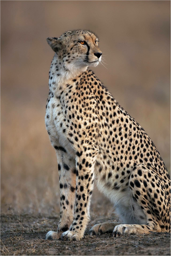

In [4]:
from fastdownload import download_url
dest = 'cheetah.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

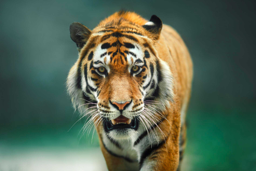

In [5]:
download_url(search_images('tiger photos', max_images=1)[0], 'tiger.jpg', show_progress=False)
Image.open('tiger.jpg').to_thumb(256,256)

In [6]:
searches = 'cheetah','tiger'
path = Path('cheetah_or_tiger')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (125255808 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

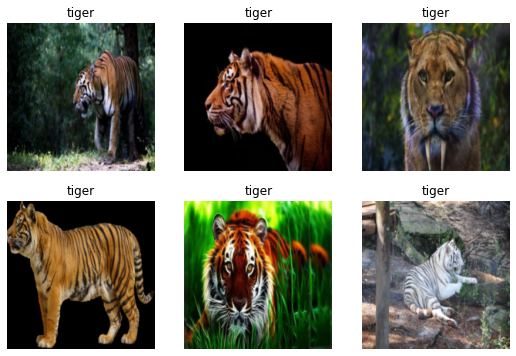

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.887432,0.208574,0.081081,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.249584,0.118982,0.067568,00:01
1,0.149298,0.088446,0.040541,00:01
2,0.101748,0.055051,0.027027,00:01


In [11]:
is_cheetah,_,probs = learn.predict(PILImage.create('cheetah.jpg'))
print(f"This is a: {is_cheetah}.")
print(f"Probability it's a cheetah: {probs[0]:.4f}")

This is a: cheetah.
Probability it's a cheetah: 0.9996
